In [4]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

### Style extractor

In [5]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [6]:
def load_img(path_to_img):
    max_dim = 1024
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [7]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

In [8]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [9]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [10]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}
    
        return {'content':content_dict, 'style':style_dict}

In [11]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [12]:
def style_content_loss(outputs, style_targets, content_targets, num_style_layers, num_content_layers, style_weight=1e-2, content_weight=1e4):
    
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [13]:
def complete_process(c_path, s_path, c_layer, s_layer, view_images = False, l_stats = False):
    
    content_image = load_img(c_path)
    style_image = load_img(s_path)
    
    if view_images:   
        plt.subplot(1, 2, 1)
        imshow(content_image, 'Content Image')
        plt.subplot(1, 2, 2)
        imshow(style_image, 'Style Image')
        
        
    num_content_layers = len(c_layer)
    num_style_layers = len(s_layer)
    
            
    extractor = StyleContentModel(s_layer, c_layer)
    results = extractor(tf.constant(content_image))
    
    if l_stats:
        print('Styles:')
        for name, output in sorted(results['style'].items()):
            print("  ", name)
            print("    shape: ", output.numpy().shape)
            print("    min: ", output.numpy().min())
            print("    max: ", output.numpy().max())
            print("    mean: ", output.numpy().mean())
            print()

        print("Contents:")
        for name, output in sorted(results['content'].items()):
            print("  ", name)
            print("    shape: ", output.numpy().shape)
            print("    min: ", output.numpy().min())
            print("    max: ", output.numpy().max())
            print("    mean: ", output.numpy().mean())
            
            
    #Run Gradient Descend        
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']
    image = tf.Variable(content_image)
    return image, extractor, style_targets, content_targets, num_style_layers, num_content_layers

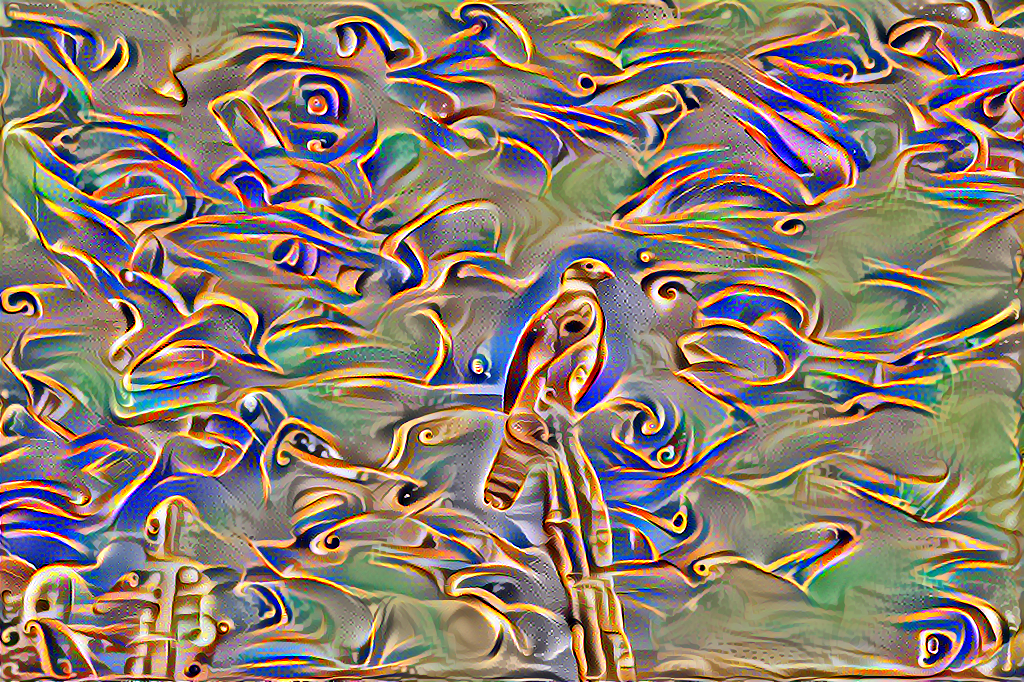

Train step: 1000
Total time: 5131.2


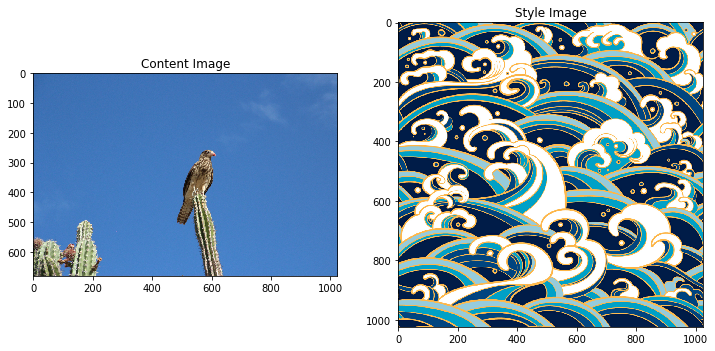

In [21]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
total_variation_weight=30

@tf.function()
def train_step(image, extractor, style_targets, content_targets, num_style_layers, num_content_layers):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, style_targets, content_targets, num_style_layers, num_content_layers)
        loss += total_variation_weight*tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    
    
    
#Define paths
c_name = 'tatacoa_1.jpg'
s_name = 'waves.jpg'
c_path = r'C:\Users\usuario\Documents\Proyectos\NeuralStyleTransfer\content\\' + c_name 
s_path = r'C:\Users\usuario\Documents\Proyectos\NeuralStyleTransfer\styles\\' + s_name

#Load vgg model
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
# for layer in vgg.layers:
#     print(layer.name)

#Choose layers for content loss and style loss
c_layer = ['block5_pool'] 
s_layer = ['block3_conv1', 'block4_conv1', 'block5_conv1']

# c_layer = ['block5_conv2'] 
# s_layer = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']


image, extractor, style_targets, content_targets, num_style_layers, num_content_layers = complete_process(c_path, s_path, c_layer, s_layer, view_images =  True, l_stats = False)

start = time.time()
epochs = 100
steps_per_epoch = 10
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, extractor, style_targets, content_targets, num_style_layers, num_content_layers)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
  
    end = time.time()
print("Total time: {:.1f}".format(end-start))

In [20]:
for layer in vgg.layers:
    print(layer.name)

input_5
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [23]:
save_img = tensor_to_image(image)
save_img.save( 'output/'+ c_name.replace('.jpg', '') + '_' + s_name.replace('.jpg', '') + '_' + str(epochs*steps_per_epoch) + '.jpg')